In [26]:
!pip install pyswarms

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit
import pyswarms as ps

In [ ]:
#Define constants - Constants used before fitting data based on lit review. 

#hr^-1
alpha0 = 0.54
alphaI = 20
alphaR = 1
alphaG = 100
alphaG_deac = 10
alphaT = 0.54
alpha_Act0 = 0.05
alpha_Act = 20

nA = 10**3
nG = 1

k1R = 1  #hr-1
k2R = 2  #hr-1
kd1 = 2 #nM
kd2 = 0.01 #nM
kcasR = 2  #hr-1
kdCas = 2.7 #nM
KM = 10 #nM
kActR = 40 #hr-1
kdAct = 20.2 #nM

#hr-1
dR = 1.386
dA = 0.0289
dCas = 1.0397
dG = 1.0397
dc = 1.386
dsspB = 5




### Constants used in all model fit and simulations
r = 1.7 #hr-1  <br>
K = 10**12  #CFU/mL  <br>
pT = 25 #nM  <br>
pTsponge = 50  #nM  <br>
Vc = 10**(-12)  #mL Volume of one cell  <br>
mu = 1.3 #hr-1  <br>
alphaGdeac = 0.1*alphaG  <br>
nA = 100  <br>


In [2]:
global t, data, pT
t = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,
13.0,13.5,14.0,14.5,15.0,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0,20.5,21.0,21.5,22.0,22.5,23.0,23.5,24.0,24.5,
25.0,25.5,26.0,26.5,27.0,27.5,28.0,28.5,29.0,29.5,30.0,30.5,31.0,31.5,32.0,32.5,33.0,33.5,34.0,34.5,35.0,35.5,36.0,36.5,37.0,
37.5,38.0,38.5,39.0,39.5,40.0,40.5,41.0,41.5,42.0,42.5,43.0,43.5,44.0,44.5,45.0,45.5,46.0,46.5,47.0,47.5])

data = np.array([474,509.3333333,657.3333333,748.6666667,889.6666667,1001.333333,1213,1468.666667,1639.666667,1834.333333,
2040.333333,2255.666667,2447.333333,2650,2839.666667,3053.666667,3218.333333,3386,3510,3596.333333,3634,3657,3651,3622,
3604.666667,3541.333333,3451,3359.666667,3259.666667,3149.666667,3055.666667,2949.333333,2860,2781.666667,2709.666667,
2647.666667,2610.666667,2560.333333,2506,2449,2396.333333,2338.333333,2270.333333,2214,2142.666667,2096.333333,2044,
1988.666667,1947.666667,1910.666667,1868,1843.333333,1810,1776.333333,1759,1725.666667,1708,1681,1654.666667,1627.333333,1607.333333,
1594.333333,1563.333333,1540.333333,1527.333333,1504.666667,1482.333333,1467.333333,1453,1428.333333,1410.666667,1397.666667,
1379.666667,1367.666667,1355.333333,1348,1334.333333,1321,1312.666667,1302,1282.333333,1280.666667,1261.666667,1244,1229.333333,
1214.333333,1198.333333,1188.333333,1172.333333,1154.333333,1148,1134.666667,1113.333333,1108.333333,1094.666667,1088.333333
])
                
data = np.reshape(data, (96,1))
pT = 25 #nM

In [3]:
#Function to generate ODEs for the qCRISPRi system

def ode_gen_qCRISPRi(y, t, p ):
    #unpack y values. 
    LuxR, dCas9, A, LuxR_A, P0, P1, pC, pD, N, GFP  = y
    
    alpha0 = p['alpha0']
    alphaI = p['alphaI']
    alphaR = p['alphaR']
    alphaG = p['alphaG']

    k1R = p['k1R']
    k2R = p['k2R']
    kcasR = p['kcasR'] 
    kd1 = p['kd1']
    kd2 = p['kd2'] 
    kdCas = p['kdCas'] 
    dG = p['dG']
    dR = p['dR'] 
    dA = p['dA'] 
    dCas = p['dCas'] 
    m = p['m']
    c = p['c'] 
   
    
    values = [
              alphaR*pT - 2*(k1R/kd1)*(LuxR)*(A) + 2*k1R*LuxR_A - (1.3+ dR)*LuxR,   #LuxR
              alphaI*P1 + alpha0*P0 - ( 1.3+ dCas)*dCas9 -(kcasR/kdCas)*dCas9*pC + kcasR*pD,    #dCas9
              (alphaI*P1 + alpha0*P0)*(1000)*(10**(-12))*N + k1R*LuxR_A - (k1R/kd1)*(LuxR)*(A)  - (1.3+dA)*A,  #AHL
              (k1R/kd1)*(LuxR)*(A) - k1R*LuxR_A - (k2R/kd2)*LuxR_A*P0 + k2R*P1 - (1.3+ dR)*LuxR_A ,  #LuxR_A
              -(k2R/kd2)*LuxR_A*P0 + k2R*P1,  #P0 Inactive promoter (basal/leaky expression)
              (k2R/kd2)*LuxR_A*P0 - k2R*P1,  #P1 Active promoter (LuxR:AHL activated)
              -(kcasR/kdCas)*dCas9*pC + kcasR*pD,  # pC - Constitutive promoter
              (kcasR/kdCas)*dCas9*pC - kcasR*pD,  # pD - dCas9 bound repressed promoter
              1.7*N*(1- N/(10**12)),  #N (cell density CFU/l)
              m*(alphaG*pC + alphaG*0.1*pD - (1.3+ dG)*GFP) +c] #GFP Cas9 repressed
              #alphaG*pT - (1.3+ dG)*GFPc] #GFP just constitutive (control)       no need for model fit       
    
    return(values)

In [4]:
def g(t, x0, p):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    sol = odeint(ode_gen_qCRISPRi, x0, t, args=(p,))
    return sol


In [5]:
def least_squares(gfp, data):
    return(sum([(i - j)**2 for i, j in zip(gfp, data)]))

In [6]:
def residual(particles):
    x0 = [0, 0, 0, 0, 25, 0, 25, 0, 10**7, 1000]
    obj_value = []
    for X in particles:
        p = {'alpha0': X[0],
             'alphaI': X[1],
             'alphaR': X[2],
             'alphaG': X[3],
             'k1R'   : X[4],
             'k2R'   : X[5],
             'kcasR' : X[6],
             'kd1'   : X[7],
             'kd2'   : X[8],
             'kdCas' : X[9],
             'dG'    : X[10],
             'dR'    : X[11],
             'dA'    : X[12],
             'dCas'  : X[13],
             'm'     : X[14],
             'c'     : X[15]}
        model_sol = g(t, x0, p)
        GFP = np.reshape(model_sol[:, 9], (96,1))
        obj_value.append(least_squares(GFP, data)[0])
    return (obj_value)
  

In [14]:
# Set-up hyperparameters
options = { 'c1' : 2.8,  'c2' : 2,  'w' :0.9}

constraints = (np.array([0.25, 7 , 1 , 100 , 0,    0,    0,   0,   0, 2.2, 0.7, 0.5, 0.001, 0.5, 0,   25]),
               np.array([ 0.6, 40, 60 , 350 , 150, 150, 150, 200, 200,  3,   2,   3,   0.1,   2,  1.5, 400]))


# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10000, dimensions=16, options=options, bounds = constraints)

# Perform optimization
cost, pos = optimizer.optimize(residual, iters=12)



2023-10-25 13:55:59,985 - pyswarms.single.global_best - INFO - Optimize for 12 iters with {'c1': 2.8, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████|12/12, best_cost=5.59e+7
2023-10-25 15:14:59,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 55926183.80479202, best pos: [3.43478459e-01 3.44351362e+01 3.61931935e+00 3.37832755e+02
 1.37224519e+00 2.19446834e-01 1.67052749e+01 2.76528977e+00
 1.86278847e+02 2.69729983e+00 9.51402957e-01 6.02702412e-01
 7.19392653e-02 1.62020938e+00 6.16825274e-02 2.09895994e+02]


In [18]:
pos = [4.52222501e-01, 1.64685383e+01, 9.71411490e+00, 3.18300218e+02,
 5.40972904e+01, 1.06212496e+02, 1.15674869e-02 ,7.74218926e+01,
 1.92404888e+02, 2.63710233e+00, 1.10282819e+00 ,2.56169162e+00,
 2.09383329e-02, 1.51064576e+00 ,7.62956824e-02, 1.50643056e+02]

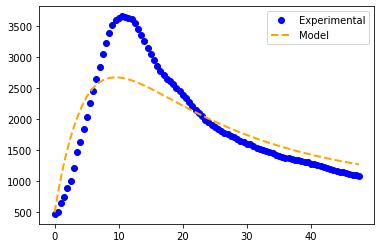

In [8]:
p = {'alpha0': pos[0],
     'alphaI': pos[1],
     'alphaR': pos[2],
     'alphaG': pos[3],
     'k1R'   : pos[4],
     'k2R'   : pos[5],
     'kcasR' : pos[6],
     'kd1'   : pos[7],
     'kd2'   : pos[8],
     'kdCas' : pos[9],
     'dG'    : pos[10],
     'dR'    : pos[11],
     'dA'    : pos[12],
     'dCas'  : pos[13],
     'm'     : pos[14],
     'c'     : pos[15]}
sim_gfp = g(t, [0, 0, 0, 0, 25, 0, 25, 0, 10**7, 500], p)
plt.plot(t, data, 'o', c= 'blue', label = 'Experimental')
plt.plot(t, sim_gfp[:,9], '--', linewidth=2, c='orange', label = 'Model');
plt.legend()

In [27]:
data = pd.DataFrame(sim_gfp, columns =  ['LuxR', 'dCas9', 'AHL', 'LuxR_AHL', 'InacP', 'AcP', 'pC', 'pD', 'N', 'GFP'])
data

,LuxR,dCas9,AHL,LuxR_AHL,InacP,AcP,pC,pD,N,GFP
0,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,25.000000,0.000000,1.000000e+07,500.000000
1,422.575738,0.415737,0.003757,0.035828,24.999990,0.000010,22.016987,2.983013,2.339616e+07,871.882098
2,585.517620,0.856117,0.007512,0.100184,24.999951,0.000049,19.467495,5.532505,5.473703e+07,1177.096550
3,648.153094,1.314494,0.016323,0.241277,24.999853,0.000147,17.371587,7.628413,1.280559e+08,1427.116475
4,671.775291,1.765179,0.037060,0.567891,24.999620,0.000380,15.707434,9.292566,2.995543e+08,1632.200023
...,...,...,...,...,...,...,...,...,...,...
91,0.055133,182.824920,267426.398913,343.962068,13.794841,11.205159,0.399169,24.600831,1.000000e+12,1754.799382
92,0.054712,184.217856,269486.551563,343.963283,13.709389,11.290611,0.396198,24.603802,1.000000e+12,1754.316833
93,0.054301,185.595458,271524.029630,343.964482,13.624877,11.375123,0.393303,24.606697,1.000000e+12,1753.850602
94,0.053901,186.957896,273539.082518,343.965665,13.541295,11.458705,0.390482,24.609518,1.000000e+12,1753.399873


In [28]:
sim_gfp[:,9]

array([ 500.        ,  871.88209846, 1177.09654975, 1427.11647497,
       1632.20002305, 1801.19989181, 1941.45846605, 2058.82073772,
       2157.71948558, 2241.21889191, 2310.82358112, 2365.69618486,
       2401.45744718, 2414.40020592, 2407.80408791, 2388.38165855,
       2361.76732544, 2331.55700628, 2299.87629309, 2267.97970433,
       2236.61928279, 2206.24910837, 2177.13930531, 2149.44218389,
       2123.23248451, 2098.53298923, 2075.33145507, 2053.59212416,
       2033.26372141, 2014.28511617, 1996.58933204, 1980.10642936,
       1964.76556642, 1950.49646011, 1937.23041901, 1924.90104923,
       1913.44472308, 1902.80087208, 1892.91215039, 1883.72450379,
       1875.18713721, 1867.25250964, 1859.87619206, 1853.01677376,
       1846.63572082, 1840.69723256, 1835.16808937, 1830.01750715,
       1825.21697667, 1820.74011985, 1816.56255976, 1812.66176128,
       1809.01691274, 1805.60881099, 1802.41975021, 1799.43338428,
       1796.63464109, 1794.00959857, 1791.54545321, 1789.23039

In [ ]:
#new equations
best cost: 18779456.100831766, best pos: [2.66391776e-01 2.16558908e+01 4.51381342e+01 3.41765776e+02
 4.67337973e+01 6.81169079e+01 1.29405391e-03 1.79435486e+02
 1.74874356e+02 2.90415210e+00 1.94788306e+00 1.28728812e+00
 5.71430159e-02 1.70540840e+00 7.34923668e-02 1.33396605e+02]

In [ ]:
final params used: (old data)
    cost:3.95*10**6
    params: 
        [2.50951495e-01 7.01443237e+00 5.83664524e+01 2.90774779e+02
 8.08792034e+01 6.55446091e+01 3.46409094e-01 1.05474030e+02
 1.50412360e+02 2.89303787e+00 8.64890773e-01 2.45014936e+00
 9.37285933e-02 1.69998133e+00 1.97918626e-01 3.09399320e+02]

In [ ]:
# new data params 
best cost: 16964747.67712104, best pos: [4.52222501e-01, 1.64685383e+01, 9.71411490e+00, 3.18300218e+02,
 5.40972904e+01, 1.06212496e+02, 1.15674869e-02 ,7.74218926e+01,
 1.92404888e+02, 2.63710233e+00, 1.10282819e+00 ,2.56169162e+00,
 2.09383329e-02, 1.51064576e+00 ,7.62956824e-02, 1.50643056e+02]
        
        


In [ ]:
with open('fitparams.txt', 'w') as file:
    file.write('Cost: \n')
    file.write('\n'.join([str(cost)]))
    file.write('\nParams: \n')
    file.write('\n'.join(str(param) for param in pos))
    


In [ ]:
p = {'alpha0': X[0],
             'alphaI': X[1],
             'alphaR': X[2],
             'alphaG': X[3],
             'k1R'   : X[4],
             'k2R'   : X[5],
             'kcasR' : X[6],
             'kd1'   : X[7],
             'kd2'   : X[8],
             'kdCas' : X[9],
             'dG'    : X[10],
             'dR'    : X[11],
             'dA'    : X[12],
             'dCas'  : X[13],
             'm'     : X[14],
             'c'     : X[15]}

alpha0 and alphaI relation:
http://parts.igem.org/Part:BBa_R0062:Experience

In [46]:
cost = least_squares([1,1,1,1], [2,2,3,3])
cost

10

In [17]:
alpha0 = 0.275
a = [round(alpha0/2, 1)]
a

[0.1]